# Анализ пространственных данных. Домашнее задание №1

Данные для выполнения заданий можно найти [здесь](https://yadi.sk/d/xBemeb0ODlhCAQ?w=1)

Дедлайн: __20 октября 2020 г. 09:00__

**ФИО: Наумовский Алексей Александрович**

**Группа: DS-12**

## Задание №1. Reading coordinates from a file and creating a geometries. 4 балла.

One of the "classical" problems in GIS is the situation where you have a set of coordinates in a file and you need to get them into a map (or into a GIS-software). Dataset `travelTimes_2015_Helsinki.txt` consist of travel times between specific locations in Helsinki Region.

1. Read the data into memory.
2. Read 4 columns `from_x`, `from_y`, `to_x`, `to_y` from the data.
3. Create two lists called __orig_points__ and __dest_points__
4. Iterate over the rows of your numpy array and add Shapely Point -objects into the __orig_points__ -list and __dest_point__ -list representing the origin locations and destination locations accordingly.

`from_x`: x-coordinate of the __origin__ location (longitude)

`from_y`: y-coordinate of the __origin__ location (latitude)

`to_x`: x-coordinate of the __destination__ location (longitude)

`to_y`: y-coordinate of the __destination__ location (latitude)

### Packages:

In [1]:
# Import packages
%matplotlib inline
import os
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
import earthpy as et
import pandas as pd
import seaborn as sns
from shapely.geometry import Point, LineString, Polygon
from geopy.distance import great_circle
import mapclassify
import numpy as np
import re

### Proc/Func:

In [2]:
def create_point(x, y):
    return Point(x, y)

In [3]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

In [4]:
def get_to_id(idx):
    if (idx == -1): return 0
    return re.findall(r'[ 0-9]+', pt_columns_list[idx])[0]

### 1.1. Read data

In [5]:
df_travelTimes = pd.read_csv('travelTimes_2015_Helsinki.txt', sep=";")

In [6]:
df_travelTimes.head(3)

,from_id,to_id,fromid_toid,route_number,at,from_x,from_y,to_x,to_y,total_route_time,route_time,route_distance,route_total_lines
0,5861326,5785640,5861326_5785640,1,08:10,24.970438,60.311917,24.856034,60.399941,125.0,99.0,22917.6,2.0
1,5861326,5785641,5861326_5785641,1,08:10,24.970438,60.311917,24.860568,60.400014,123.0,102.0,23123.5,2.0
2,5861326,5785642,5861326_5785642,1,08:10,24.970438,60.311917,24.865102,60.400086,125.0,103.0,23241.3,2.0


In [7]:
df_travelTimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14643 entries, 0 to 14642
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   from_id            14643 non-null  int64  
 1   to_id              14643 non-null  int64  
 2   fromid_toid        14643 non-null  object 
 3   route_number       14643 non-null  int64  
 4   at                 14643 non-null  object 
 5   from_x             14643 non-null  float64
 6   from_y             14643 non-null  float64
 7   to_x               14643 non-null  float64
 8   to_y               14643 non-null  float64
 9   total_route_time   14643 non-null  float64
 10  route_time         14643 non-null  float64
 11  route_distance     14643 non-null  float64
 12  route_total_lines  14643 non-null  float64
dtypes: float64(8), int64(3), object(2)
memory usage: 1.5+ MB


In [8]:
df_travelTimes.describe()

,from_id,to_id,route_number,from_x,from_y,to_x,to_y,total_route_time,route_time,route_distance,route_total_lines
count,14643.0,1.464300e+04,14643.0,14643.000000,1.464300e+04,14643.000000,14643.000000,14643.000000,14643.000000,14643.000000,14643.000000
mean,5861326.0,5.899055e+06,1.0,24.970438,6.031192e+01,24.851692,60.263283,-1169.186176,-1184.522650,21123.669243,-1247.658142
std,0.0,5.143595e+04,0.0,0.000000,7.105670e-15,0.199089,0.063512,11118.610201,11116.870375,16843.771019,11109.732155
min,5861326.0,5.778014e+06,1.0,24.970438,6.031192e+01,24.480485,60.105476,-99999.990000,-99999.990000,-99999.990000,-99999.990000
25%,5861326.0,5.859362e+06,1.0,24.970438,6.031192e+01,24.685565,60.213878,55.000000,44.000000,14985.600000,2.000000
50%,5861326.0,5.898411e+06,1.0,24.970438,6.031192e+01,24.845547,60.264803,75.000000,60.000000,21871.500000,2.000000
75%,5861326.0,5.940286e+06,1.0,24.970438,6.031192e+01,25.023525,60.312816,102.000000,82.000000,29817.100000,3.000000
max,5861326.0,6.018254e+06,1.0,24.970438,6.031192e+01,25.274518,60.409131,207.000000,181.000000,49314.300000,4.000000


In [9]:
sum(df_travelTimes.isnull().sum())

0

### 1.2. Read 4 columns from_x, from_y, to_x, to_y from the data

In [10]:
data = df_travelTimes[['from_x', 'from_y', 'to_x', 'to_y']]

# Lattitude must be FIRST!
data.columns = ['from_y', 'from_x', 'to_y', 'to_x']
data = data[['from_x', 'from_y', 'to_x', 'to_y']]
data.head()

,from_x,from_y,to_x,to_y
0,60.311917,24.970438,60.399941,24.856034
1,60.311917,24.970438,60.400014,24.860568
2,60.311917,24.970438,60.400086,24.865102
3,60.311917,24.970438,60.400159,24.869636
4,60.311917,24.970438,60.397478,24.842582


### 1.3. Create two lists called orig_points and dest_points

### 1.4. add Shapely Point -objects into the orig_points -list and dest_point -list representing the origin locations and destination locations accordingly.

In [11]:
orig_points = pd.DataFrame(list(data[['from_x', 'from_y']].itertuples(index=False, name=None)),\
             columns=['x','y']).apply(lambda v: create_point(v.x, v.y), axis = 1)

In [12]:
dest_points = pd.DataFrame(list(data[['to_x', 'to_y']].itertuples(index=False, name=None)),\
             columns=['x','y']).apply(lambda v: create_point(v.x, v.y), axis = 1)

In [13]:
dest_points[5], orig_points[5]

(<shapely.geometry.point.Point at 0x214b9c18610>,
 <shapely.geometry.point.Point at 0x214b98da4c0>)

#### Bonus 1

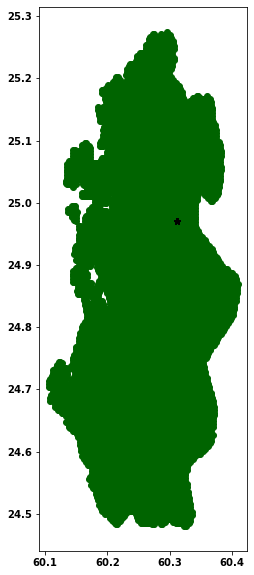

In [14]:
fig, ax = plt.subplots(1,1, figsize=(5,10))
gpd.GeoDataFrame(dest_points, columns=['geometry']).plot(color='darkgreen',ax=ax)
gpd.GeoDataFrame(orig_points, columns=['geometry']).plot(color='black',ax=ax, marker = '*');

## Задание №2. Creating LineStrings that represent the movements. 6 баллов.

Please use data from previous task:

1. Create a list called `lines`
2. Iterate over the __orig_points__ and __dest_points__ lists and create a Shapely _LineString_ -object between the origin and destination point
3. Add that line into the `lines` -list.
4. Find out what is the average (Euclidian) distance of all the origin-destination _LineStrings_ that we just created, and print it out.

### 2.1. Create a list called lines

In [15]:
lines = []

### 2.2. Iterate over the orig_points and dest_points lists and create a Shapely LineString 

### 2.3. Add that line into the lines -list.

In [16]:
for origin, destination in tqdm(zip(orig_points, dest_points)):
    cur_line = LineString([origin, destination])
    lines.append(cur_line)

14643it [00:01, 11848.60it/s]


#### Bonus 2

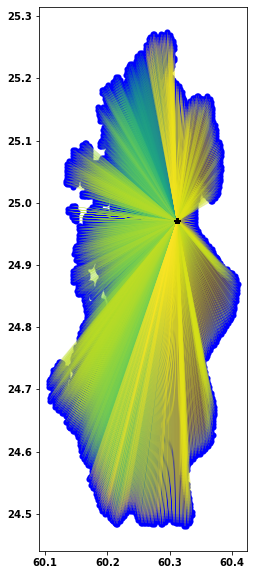

In [17]:
fig, ax = plt.subplots(1,1,figsize=(10, 10))
df_temp = gpd.GeoDataFrame(orig_points, columns=['geometry'])
gpd.GeoDataFrame(lines, columns=['geometry']).boundary.plot(ax=ax, linewidth = 0.1, color='blue')
gpd.GeoDataFrame(lines, columns=['geometry']).reset_index().plot(ax=ax, linewidth = 0.2, column="index")
ax.plot(df_temp.geometry.x, df_temp.geometry.y ,color='black', marker = '*')
plt.show()
del df_temp

### 2.4. Find out what is the average (Euclidian) distance of all the origin-destination LineStrings that we just created, and print it out.

In [18]:
df_distances = pd.DataFrame(lines, columns=['distance']).applymap(lambda line: great_circle(*line.xy).meters)

In [19]:
average_distance = df_distances.mean()[0]
print(f'{round(average_distance,4)} meters')

4769168.6552 meters


#### Bonus 3

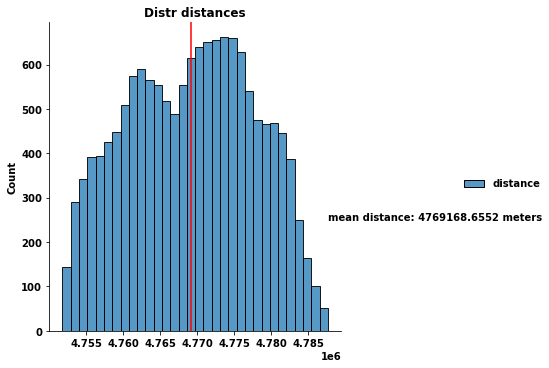

In [20]:
g = sns.displot(df_distances)
g.ax.set_title("Distr distances");
g.ax.axvline(x=average_distance, color='r')
plt.text(df_distances.distance.max(),250, 'mean distance: ' + str(round(average_distance,4)) + ' meters');

## Задание №3. Points to map. 4 балла.

Aim is to plot a set of x and y coordinates that we should read from a `some_posts.csv`. The data has 81379 rows and consists of locations and times of social media posts inside Kruger national park in South Africa.

1. Read the data into memory.
2. Create an empty column called `geometry` where you will store shapely _Point_ objects
3. Iterate over the rows of the DataFrame (__x__ and __y__ -coordinates) and insert _Point_ objects into column `geometry`
4. Convert that DataFrame into a GeoDataFrame
5. Update the CRS for coordinate system as WGS84 (i.e. epsg code: 4326)
6. Save the data into a Shapefile called `Kruger_posts.shp`
7. Create a simple map of those points using .plot() -funtion

`lat`: y-coordinate of the post

`lon`: x-coordinate of the post

`timestamp`: Time when the post was uploaded

`userid`: userid

### 3.1. Read the data into memory.

In [21]:
# Lattitude must be FIRST!
df_posts = pd.read_csv("some_posts.txt", sep=",", names=['y', 'x','timestamp','userid'], header=0)
df_posts = df_posts[['x', 'y','timestamp','userid']]
df_posts.sample(5)

,x,y,timestamp,userid
40076,31.779795,-24.393185,2015-10-22 15:37,84645843
60274,31.592609,-24.992528,2015-10-18 02:47,31263244
67332,31.149272,-23.950609,2015-10-20 15:15,90005067
73890,31.574876,-23.853174,2015-07-16 15:43,4187526
6312,31.098102,-25.082323,2015-06-31 13:43,33934761


In [22]:
df_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81379 entries, 0 to 81378
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   x          81379 non-null  float64
 1   y          81379 non-null  float64
 2   timestamp  81379 non-null  object 
 3   userid     81379 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 2.5+ MB


In [23]:
df_posts.describe()

,x,y,userid
count,81379.000000,81379.000000,8.137900e+04
mean,31.213431,-25.005480,4.944360e+07
std,0.279501,0.516339,2.867361e+07
min,30.187638,-25.557627,1.630100e+04
25%,30.996890,-25.455344,2.442590e+07
50%,31.114005,-25.158814,4.865128e+07
75%,31.401063,-24.606298,7.416904e+07
max,32.033100,-22.352167,9.999579e+07


In [24]:
df_posts.userid.nunique()

14990

### 3.2. Create an empty column called geometry where you will store shapely Point objects

In [25]:
df_posts['geometry'] = None;

In [26]:
df_posts.head()

,x,y,timestamp,userid,geometry
0,31.484633,-24.980792,2015-07-07 03:02,66487960,None
1,31.508906,-25.499225,2015-07-07 03:18,65281761,None
2,30.930866,-24.342578,2015-03-07 03:38,90916112,None
3,31.519718,-24.854614,2015-10-07 05:04,37959089,None
4,31.520836,-24.921069,2015-10-07 05:19,27793716,None


### 3.3. Iterate over the rows of the DataFrame (x and y -coordinates) and insert Point objects into column geometry

In [27]:
df_posts['geometry'] = df_posts.apply(lambda f: create_point(f.x, f.y), axis=1)

In [28]:
df_posts.head()

,x,y,timestamp,userid,geometry
0,31.484633,-24.980792,2015-07-07 03:02,66487960,POINT (31.484633302 -24.980792492)
1,31.508906,-25.499225,2015-07-07 03:18,65281761,POINT (31.508905612 -25.499224667)
2,30.930866,-24.342578,2015-03-07 03:38,90916112,POINT (30.930866066 -24.342578456)
3,31.519718,-24.854614,2015-10-07 05:04,37959089,POINT (31.519718439 -24.85461393)
4,31.520836,-24.921069,2015-10-07 05:19,27793716,POINT (31.520835558 -24.921068894)


### 3.4. Convert that DataFrame into a GeoDataFrame

In [29]:
df_gpd_posts = gpd.GeoDataFrame(df_posts)
df_gpd_posts.head()

,x,y,timestamp,userid,geometry
0,31.484633,-24.980792,2015-07-07 03:02,66487960,POINT (31.48463 -24.98079)
1,31.508906,-25.499225,2015-07-07 03:18,65281761,POINT (31.50891 -25.49922)
2,30.930866,-24.342578,2015-03-07 03:38,90916112,POINT (30.93087 -24.34258)
3,31.519718,-24.854614,2015-10-07 05:04,37959089,POINT (31.51972 -24.85461)
4,31.520836,-24.921069,2015-10-07 05:19,27793716,POINT (31.52084 -24.92107)


### 3.5. Update the CRS for coordinate system as WGS84 (i.e. epsg code: 4326)

In [30]:
df_gpd_posts.crs = "EPSG:4326"
df_gpd_posts.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### 3.6. Save the data into a Shapefile called Kruger_posts.shp

In [31]:
if not os.path.exists("Kruger_posts"):
    os.makedirs("Kruger_posts")

In [32]:
%%time
df_gpd_posts.to_file(filename="Kruger_posts/Kruger_posts.shp", driver='ESRI Shapefile')

Wall time: 19.5 s


### 3.7. Create a simple map of those points using .plot() -funtion

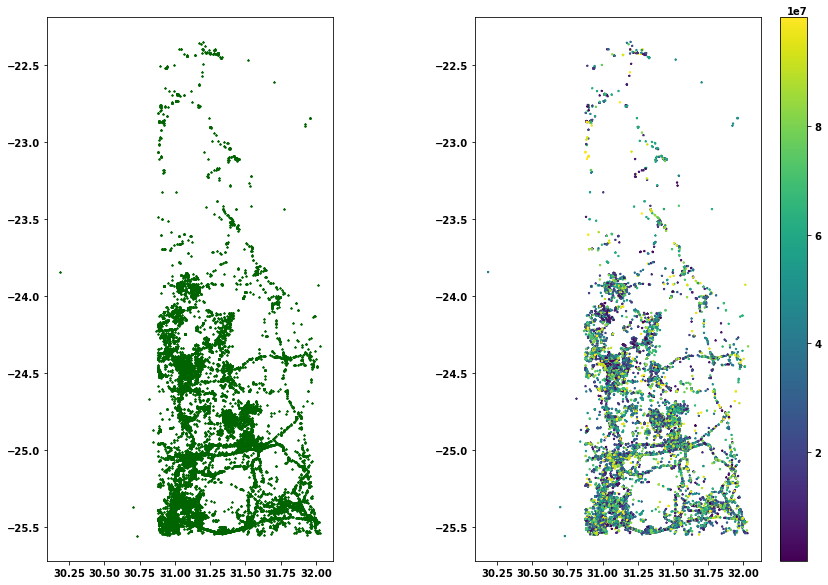

In [33]:
fig, axes = plt.subplots(1,2, figsize=(15, 10))
df_gpd_posts.plot(marker='*', ax=axes[0], color='darkgreen', markersize=3)
df_gpd_posts.plot(column='userid', marker='*', ax=axes[1], markersize=3, legend = True);

#### Bonus 4

In [34]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
Africa = world[world["continent"] == "Africa"]

In [35]:
Africa.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
11,83301151,Africa,Dem. Rep. Congo,COD,66010.0,"POLYGON ((29.34000 -4.49998, 29.51999 -5.41998..."
12,7531386,Africa,Somalia,SOM,4719.0,"POLYGON ((41.58513 -1.68325, 40.99300 -0.85829..."
13,47615739,Africa,Kenya,KEN,152700.0,"POLYGON ((39.20222 -4.67677, 37.76690 -3.67712..."


In [36]:
south_africa = Africa[Africa['name'].str.startswith('South Africa')]

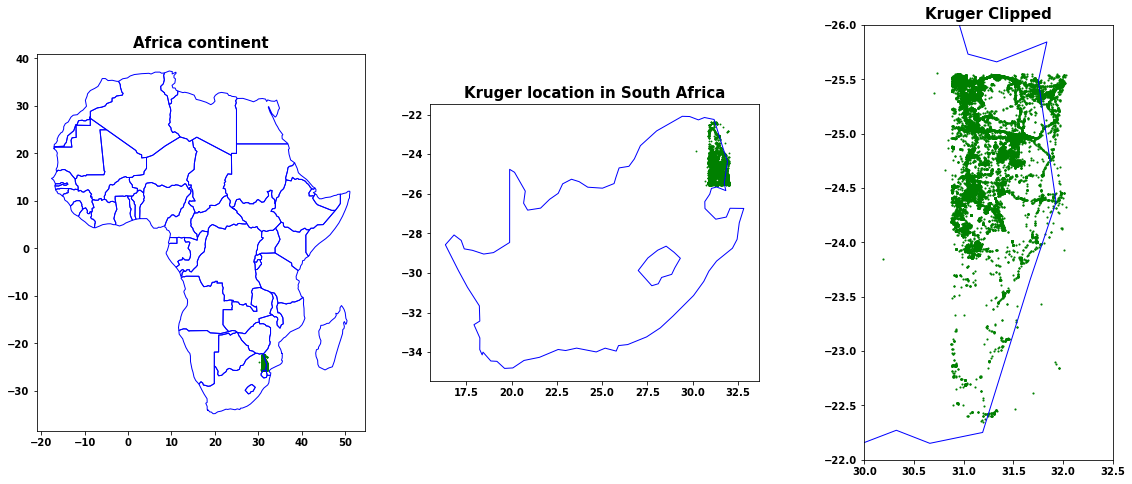

In [37]:
south_africa_Kruger_clip = gpd.clip(df_gpd_posts, south_africa)
fig, axes = plt.subplots(1,3,figsize=(20, 8))
# Africa continent
Africa.boundary.plot(ax=axes[0], color="blue", linewidth = 1)
df_gpd_posts.plot(ax=axes[0], color="green", marker = '.', markersize = 3)
axes[0].set_title("Africa continent", fontsize=15)
# south_africa clipped
south_africa.boundary.plot(ax=axes[1], color="blue", linewidth = 1)
df_gpd_posts.plot(ax=axes[1], color="green", marker = '.', markersize = 3)
axes[1].set_title("Kruger location in South Africa", fontsize=15)
# Axis limits
south_africa.boundary.plot(ax=axes[2], color="blue", linewidth = 1)
df_gpd_posts.plot(ax=axes[2], color="green", marker = '.', markersize = 5)
axes[2].set_title("Kruger Clipped", fontsize=15)
axes[2].set(xlim=[30, 32.5], ylim=[-22, -26])
plt.show()

## Задание №4. Movements of individual user. 6 баллов.

Please use data from previous task:

1. Group the data by `userid`
2. Create an empty GeoDataFrame
3. For each user:
   - sort the rows by `timestamp`
   - create _LineString_ objects based on the points
   - add the `geometry` and the `userid` into the GeoDataFrame you created in the last step
4. Determine the CRS of your GeoDataFrame to WGS84 (epsg code: 4326)
5. Save the movements of each user into a separate Shapefile
   - Name the output Shapefile based on the `userid` number

### 4.1. Group the data by userid

In [38]:
df_posts['timestamp'] = pd.to_datetime(df_posts['timestamp'], format='%Y-%m-%d %H:%M',errors='coerce')

**Внимание: В датасете есть некорретные данные даты (2015 февраля 29) - будем менять на 2015 март 01**

In [39]:
df_posts.timestamp.fillna(pd.to_datetime('20150301', format='%Y-%m-%d %H:%M'), inplace = True)

In [40]:
df_group_userid = df_posts.groupby('userid')['userid'].agg(['count'])
df_group_userid.sample(5)

,count
userid,
36704023,3
29228008,18
64035520,1
36869846,2
93263540,1


In [41]:
# отбираем только userid как минимум с двумя точками - иначе не создать LineString
df_group_userid = df_group_userid[(df_group_userid['count'] > 1)]
df_group_userid.head()

,count
userid,
16301,9
45136,2
50136,10
88775,2
88918,2


### 4.2. Create an empty GeoDataFrame

In [42]:
df_gpd_userid_lines = gpd.GeoDataFrame()

### 4.3. For each user transfrom sorted ty time Points to Line

In [43]:
df_posts.sort_values(['userid','timestamp'],inplace = True, ascending = True)

In [44]:
df_posts.head(5)

,x,y,timestamp,userid,geometry
30535,31.371200,-24.759508,2015-02-08 06:18:00,16301,POINT (31.37120 -24.75951)
30770,31.338317,-24.749845,2015-02-09 08:09:00,16301,POINT (31.33832 -24.74985)
38235,31.592000,-24.995803,2015-03-13 10:59:00,16301,POINT (31.59200 -24.99580)
38232,31.865172,-24.791483,2015-05-13 10:51:00,16301,POINT (31.86517 -24.79148)
30512,31.339430,-24.760170,2015-06-08 04:34:00,16301,POINT (31.33943 -24.76017)


In [45]:
df_gpd_userid_lines = df_posts[df_posts['userid'].isin(df_group_userid.index)].\
    groupby(['userid'])['geometry'].apply(lambda x: LineString(x.tolist()))
df_gpd_userid_lines = gpd.GeoDataFrame(df_gpd_userid_lines.reset_index())
df_gpd_userid_lines.head()

,userid,geometry
0,16301,"LINESTRING (31.37120 -24.75951, 31.33832 -24.7..."
1,45136,"LINESTRING (31.02582 -25.32131, 31.02582 -25.3..."
2,50136,"LINESTRING (31.39447 -24.76985, 31.59261 -24.9..."
3,88775,"LINESTRING (31.00036 -25.32947, 31.00036 -25.3..."
4,88918,"LINESTRING (31.55131 -25.06714, 31.59261 -24.9..."


In [46]:
df_gpd_userid_lines.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9026 entries, 0 to 9025
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   userid    9026 non-null   int64   
 1   geometry  9026 non-null   geometry
dtypes: geometry(1), int64(1)
memory usage: 141.2 KB


### 4.4. Determine the CRS of your GeoDataFrame to WGS84 (epsg code: 4326)

In [47]:
df_gpd_userid_lines.crs = "EPSG:4326"
df_gpd_userid_lines.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### 4.5. Save the movements of each user into a separate Shapefile

In [48]:
if not os.path.exists("userid_shapefiles"):
    os.makedirs("userid_shapefiles")

In [49]:
for cur_userid in tqdm(df_gpd_userid_lines.userid):
    df_gpd_userid_lines[(df_gpd_userid_lines.userid == cur_userid)]\
        .to_file(filename="userid_shapefiles/" + str(cur_userid) + ".shp", driver='ESRI Shapefile')

100%|██████████████████████████████████████████████████████████████████████████████| 9026/9026 [07:07<00:00, 21.10it/s]


## Задание №5. Join accessibility datasets into a grid and visualize them by using a classifier. 4 балла.

A dataset from `dataE4.zip` includes 7 text files containing data about accessibility in Helsinki Region and a Shapefile that contains a Polygon grid that can be used to visualize and analyze the data spatially. The datasets are:

 - `travel_times_to_[XXXXXXX]_[NAME-OF-THE-CENTER].txt` including travel times and road network distances to specific shopping center
 - `MetropAccess_YKR_grid_EurefFIN.shp` including the Polygon grid with __YKR_ID__ column that can be used to join the grid with the accessibility data
 
Find out more about the data [here](https://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix-2015/)

1. Read those travel_time data files (one by one) with Pandas and select only following columns from them:

 - `pt_r_tt`
 - `car_r_t`
 - `from_id`
 - `to_id`


2. Visualize the classified travel times (Public transport AND Car) of at least one of the shopping centers using any classification method (see [PySAL](https://pysal.org/) for more details upon classification methods). You need to classify the data into a new column in your GeoDataFrame.

### 5.1. Read those travel_time data files (one by one) with Pandas

In [50]:
shopping_centers = []
df_TravelTimes = pd.DataFrame()
txt_files = filter(lambda x: x[-4:] == '.txt', os.listdir('dataE4'))
for cur_file in tqdm(txt_files):
    df_temp = pd.read_csv('dataE4\\'+cur_file, sep=";", header=0, usecols=["pt_r_tt", "car_r_t", "from_id", "to_id"])
    df_TravelTimes = pd.concat((df_TravelTimes, df_temp), axis = 0)
    shopping_centers.append(re.findall(r'[ 0-9]+', cur_file))
del df_temp    

7it [00:00, 24.91it/s]


In [51]:
df_TravelTimes.head()

,from_id,to_id,car_r_t,pt_r_tt
0,5785640,5878070,39,131
1,5785641,5878070,39,129
2,5785642,5878070,45,129
3,5785643,5878070,46,138
4,5787544,5878070,38,115


In [52]:
shopping_centers

[['5878070'],
 ['5878087'],
 ['5902043'],
 ['5944003'],
 ['5975373'],
 ['5978593'],
 ['5980260']]

In [53]:
df_TravelTimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92617 entries, 0 to 13230
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   from_id  92617 non-null  int64
 1   to_id    92617 non-null  int64
 2   car_r_t  92617 non-null  int64
 3   pt_r_tt  92617 non-null  int64
dtypes: int64(4)
memory usage: 3.5 MB


In [54]:
df_TravelTimes.describe()

,from_id,to_id,car_r_t,pt_r_tt
count,9.261700e+04,9.261700e+04,92617.000000,92617.000000
mean,5.904463e+06,5.892964e+06,36.125258,69.867735
std,4.908522e+04,4.923179e+05,11.968579,29.610206
min,5.785640e+06,-1.000000e+00,-1.000000,-1.000000
25%,5.866837e+06,5.878087e+06,28.000000,49.000000
50%,5.903926e+06,5.944003e+06,36.000000,67.000000
75%,5.942208e+06,5.978593e+06,44.000000,89.000000
max,6.018254e+06,5.980260e+06,83.000000,232.000000


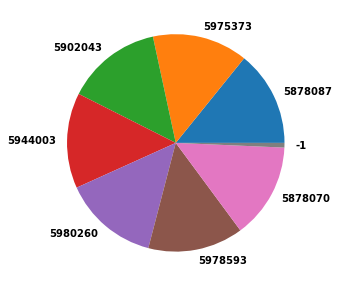

In [55]:
f, ax = plt.subplots(1,1,figsize=(5,5))
df_TravelTimes.to_id.value_counts().plot.pie(ax=ax)
ax.set_axis_off();

In [56]:
# drop to_id = - 1
df_TravelTimes = df_TravelTimes[(df_TravelTimes > 0).all(1)]

In [57]:
df_gpd_MetropAccess = gpd.read_file("dataE4\\MetropAccess_YKR_grid_EurefFIN.shp")
df_gpd_MetropAccess.head()

,x,y,YKR_ID,geometry
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6..."
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6..."
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6..."
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6..."


In [58]:
df_gpd_MetropAccess.nunique()

x             169
y             131
YKR_ID      13231
geometry    13231
dtype: int64

### 5.2. Visualize the classified travel times (Public transport AND Car) of at least one of the shopping centers using any classification method (see PySAL for more details upon classification methods). You need to classify the data into a new column in your GeoDataFrame. 

In [59]:
gpd_temp = gpd.GeoDataFrame(pd.merge(df_TravelTimes, df_gpd_MetropAccess,\
                                     how='inner', left_on = 'from_id', right_on = 'YKR_ID'))
gpd_temp.head(5)

,from_id,to_id,car_r_t,pt_r_tt,x,y,YKR_ID,geometry
0,5785640,5878070,39,131,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
1,5785640,5878087,45,134,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
2,5785640,5902043,39,121,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
3,5785640,5944003,50,157,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
4,5785640,5975373,49,137,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6..."


#### 5.2.1. Classified travel times Car

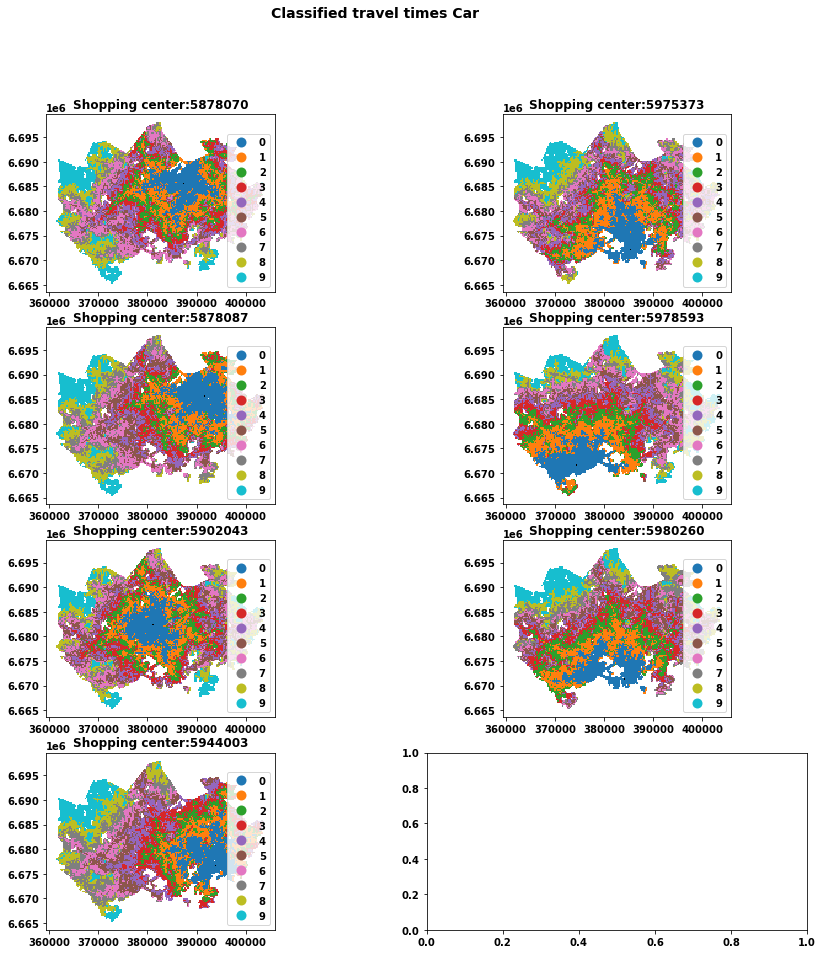

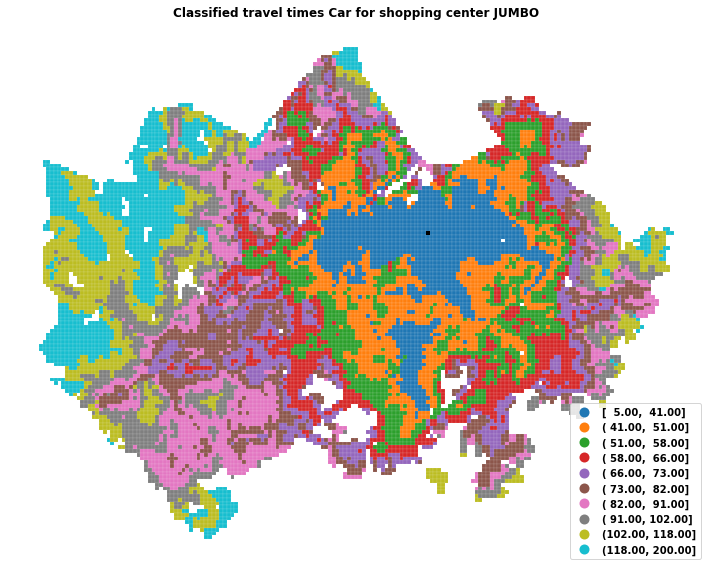

Wall time: 1min 8s


In [60]:
%%time
fig, axes = plt.subplots(4,2, figsize = (15,15))
fig.suptitle("Classified travel times Car", fontsize=14)
for idx,cur_shop_center in enumerate(shopping_centers):
    cur_df = gpd_temp[gpd_temp.to_id == np.int64(cur_shop_center)[0]]
    cur_ax = axes[idx%4][idx//4]
    q10 = mapclassify.Quantiles(cur_df.car_r_t,k=10)
    cur_df.assign(cl_car=q10.yb).plot(column='cl_car', ax=cur_ax,\
                                      categorical=True, k=10 ,legend=True, legend_kwds={'loc': 'lower right'})
    cur_ax.set_title('Shopping center:'+str(cur_shop_center[0]))
    df_gpd_MetropAccess[df_gpd_MetropAccess.YKR_ID == np.int64(cur_shop_center)[0]].\
        plot(ax = cur_ax, marker='*', markersize=1, color='Black')
    
fig, ax = plt.subplots(1, figsize = (10,10))
q10 = mapclassify.Quantiles(gpd_temp[gpd_temp.to_id == 5878070].pt_r_tt, k=10)
mapping = dict([(i,s) for i,s in enumerate(q10.get_legend_classes())])   
gpd_temp[gpd_temp.to_id == 5878070].assign(cl=q10.yb).plot(column='cl', categorical=True, \
        k=10, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True,
                          legend_kwds={'loc': 'lower right'})
ax.set_axis_off()
ax.set_title("Classified travel times Car for shopping center JUMBO")
replace_legend_items(ax.get_legend(), mapping)
df_gpd_MetropAccess[df_gpd_MetropAccess.YKR_ID == 5878070].plot(ax=ax, marker='*', markersize=1000, color='Black')
plt.tight_layout()    
plt.show()      

#### 5.2.2. Classified travel times PT

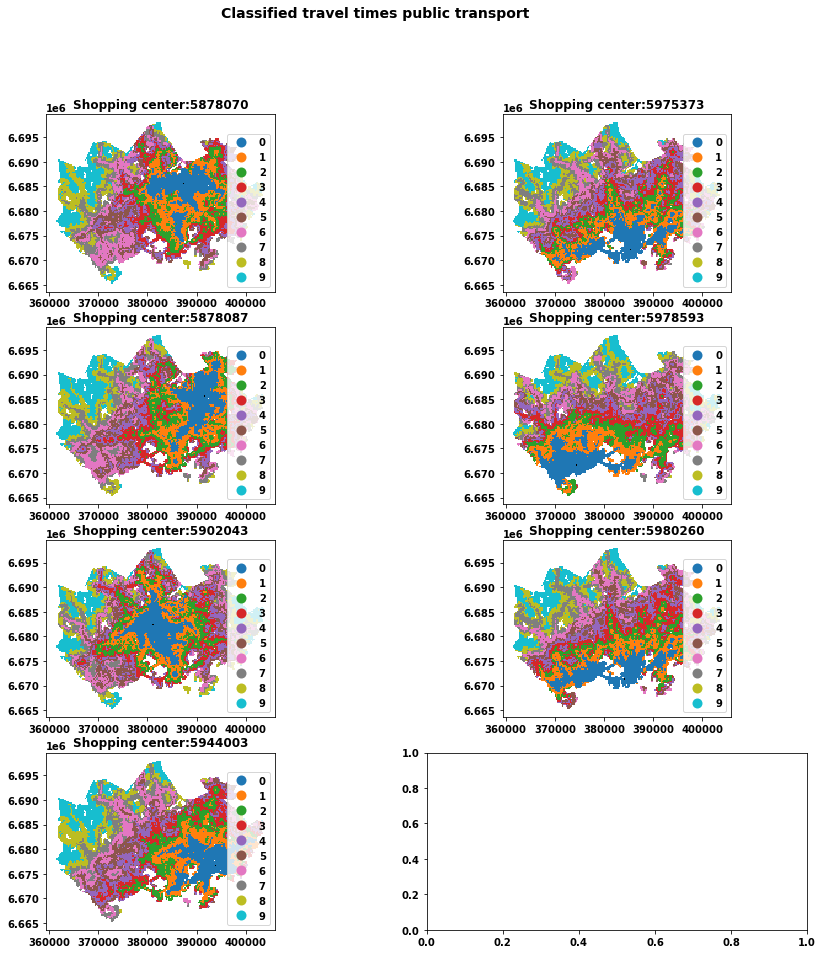

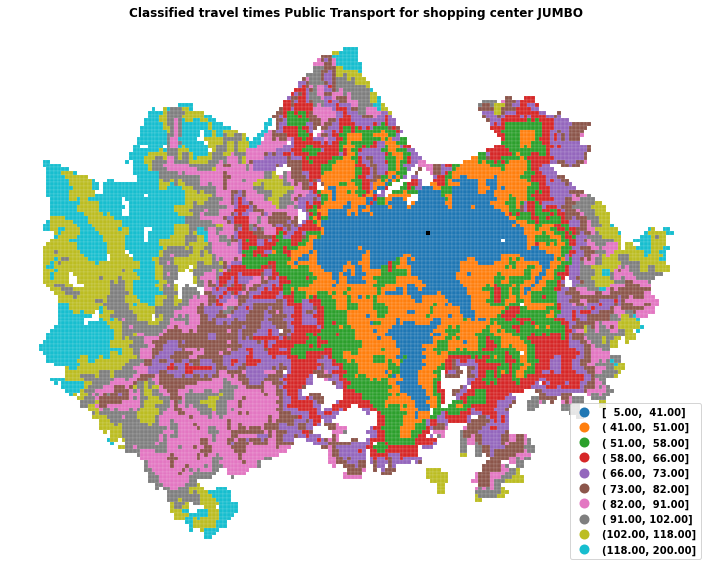

Wall time: 1min 9s


In [61]:
%%time
fig, axes = plt.subplots(4,2, figsize = (15,15))
fig.suptitle("Classified travel times public transport", fontsize=14)
for idx,cur_shop_center in enumerate(shopping_centers):
    cur_df = gpd_temp[gpd_temp.to_id == np.int64(cur_shop_center)[0]]
    cur_ax = axes[idx%4][idx//4]
    q10 = mapclassify.Quantiles(cur_df.pt_r_tt,k=10)
    cur_df.assign(cl_pt=q10.yb).plot(column='cl_pt', ax=cur_ax,\
                                      categorical=True, k=10 ,legend=True, legend_kwds={'loc': 'lower right'})
    cur_ax.set_title('Shopping center:'+str(cur_shop_center[0]))
    df_gpd_MetropAccess[df_gpd_MetropAccess.YKR_ID == np.int64(cur_shop_center)[0]].\
        plot(ax = cur_ax, marker='*', markersize=1, color='Black')
    
fig, ax = plt.subplots(1, figsize = (10,10))
q10 = mapclassify.Quantiles(gpd_temp[gpd_temp.to_id == 5878070].pt_r_tt, k=10)
mapping = dict([(i,s) for i,s in enumerate(q10.get_legend_classes())])   
gpd_temp[gpd_temp.to_id == 5878070].assign(cl=q10.yb).plot(column='cl', categorical=True, \
        k=10, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True,
                          legend_kwds={'loc': 'lower right'})
gpd_temp[gpd_temp.from_id == 5878070].plot(ax=ax, color='Black', marker ="*", markersize=1000)
ax.set_axis_off()
ax.set_title("Classified travel times Public Transport for shopping center JUMBO")
replace_legend_items(ax.get_legend(), mapping)
plt.tight_layout()    
plt.show()    

## Задание №6. Calculate and visualize the dominance areas of shopping centers. 6 баллов.

Please use data from previous task. The aim is to define the dominance area for each of those shopping centers based on travel time:

1. Iterate over the accessibility files one by one
2. Rename the travel time columns so that they can be identified
   - you can include e.g. the `to_id` number as part of the column name (then the column name could be e.g. "pt_r_tt_5987221")
3. Join those columns into `MetropAccess_YKR_grid_EurefFIN.shp` where __YKR_ID__ in the grid corresponds to `from_id` in the travel time data file. At the end you should have a GeoDataFrame with different columns show the travel times to different shopping centers.
4. For each row find out the __minimum__ value of __all__ `pt_r_tt_XXXXXX` columns and insert that value into a new column called `min_time_pt`. You can now also parse the `to_id` value from the column name (i.e. parse the last number-series from the column text) that had the minimum travel time value and insert that value as a number into a column called `dominant_service`. In this, way are able to determine the "closest" shopping center for each grid cell and visualize it either by travel times or by using the __YKR_ID__ number of the shopping center (i.e. that number series that was used in column name).
5. Visualize the travel times of our `min_time_pt` column using any classifier.
6. Visualize also the values in `dominant_service` column (no need to use any specific classifier). Notice that the value should be a number. If it is still as text, you need to convert it first.

### 6.1. Iterate over the accessibility files one by one

### 6.2. Rename the travel time columns so that they can be identified(postfix = to_id) 

### 6.3. Join those columns into MetropAccess_YKR_grid_EurefFIN.shp where YKR_ID in the grid corresponds to from_id in the travel time data file

In [62]:
df_gpd_MetropAccess_full = df_gpd_MetropAccess.set_index('YKR_ID')
df_gpd_MetropAccess_full = df_gpd_MetropAccess_full.dropna()

txt_files = filter(lambda x: x[-4:] == '.txt', os.listdir('dataE4'))
for cur_file in tqdm(txt_files):
    df_TravelTimes_cur = pd.read_csv('dataE4\\'+cur_file, sep=";", header=0, usecols=["pt_r_tt", "car_r_t", "from_id", "to_id"])
    df_TravelTimes_cur = df_TravelTimes_cur[(df_TravelTimes_cur > 0).all(1)]
    to_id = df_TravelTimes_cur.loc[0,'to_id']
    df_TravelTimes_cur.columns = ['from_id', 'to_id', 'car_r_t' ,'pt_r_tt_'+str(to_id)]
    df_TravelTimes_cur = df_TravelTimes_cur[['from_id','pt_r_tt_'+str(to_id)]]
    df_gpd_MetropAccess_full = df_gpd_MetropAccess_full.join(df_TravelTimes_cur.set_index('from_id'))

7it [00:00, 19.81it/s]


### 6.4.1. For each row find out the minimum value of all pt_r_tt_XXXXXX columns and insert that value into a new column called min_time_pt

In [63]:
df_gpd_MetropAccess_full['min_time_pt'] = df_gpd_MetropAccess_full.iloc[:,3:].apply(lambda x : x.min(), axis = 1)

In [64]:
df_gpd_MetropAccess_full.head(3)

,x,y,geometry,pt_r_tt_5878070,pt_r_tt_5878087,pt_r_tt_5902043,pt_r_tt_5944003,pt_r_tt_5975373,pt_r_tt_5978593,pt_r_tt_5980260,min_time_pt
YKR_ID,,,,,,,,,,,
5785640,381875.0,6697880.0,"POLYGON ((382000.000 6697750.000, 381750.000 6...",131.0,134.0,121.0,157.0,137.0,166.0,147.0,121.0
5785641,382125.0,6697880.0,"POLYGON ((382250.000 6697750.000, 382000.000 6...",129.0,130.0,115.0,154.0,134.0,164.0,142.0,115.0
5785642,382375.0,6697880.0,"POLYGON ((382500.000 6697750.000, 382250.000 6...",129.0,130.0,115.0,154.0,134.0,164.0,142.0,115.0


### 6.4.2. parse the to_id value from the column name that had the minimum travel time value and insert that value as a number into a column called dominant_service.

In [65]:
pt_columns_list = df_gpd_MetropAccess_full.columns[3:-1]
pt_columns_list

Index(['pt_r_tt_5878070', 'pt_r_tt_5878087', 'pt_r_tt_5902043',
       'pt_r_tt_5944003', 'pt_r_tt_5975373', 'pt_r_tt_5978593',
       'pt_r_tt_5980260'],
      dtype='object')

In [66]:
df_gpd_MetropAccess_full['dominant_service'] = df_gpd_MetropAccess_full.iloc[:,3:-1].\
    apply(lambda x : get_to_id(x.argmin()), axis = 1)

In [67]:
df_gpd_MetropAccess_full = df_gpd_MetropAccess_full.dropna()

In [68]:
df_gpd_MetropAccess_full.head()

,x,y,geometry,pt_r_tt_5878070,pt_r_tt_5878087,pt_r_tt_5902043,pt_r_tt_5944003,pt_r_tt_5975373,pt_r_tt_5978593,pt_r_tt_5980260,min_time_pt,dominant_service
YKR_ID,,,,,,,,,,,,
5785640,381875.0,6697880.0,"POLYGON ((382000.000 6697750.000, 381750.000 6...",131.0,134.0,121.0,157.0,137.0,166.0,147.0,121.0,5902043
5785641,382125.0,6697880.0,"POLYGON ((382250.000 6697750.000, 382000.000 6...",129.0,130.0,115.0,154.0,134.0,164.0,142.0,115.0,5902043
5785642,382375.0,6697880.0,"POLYGON ((382500.000 6697750.000, 382250.000 6...",129.0,130.0,115.0,154.0,134.0,164.0,142.0,115.0,5902043
5785643,382625.0,6697880.0,"POLYGON ((382750.000 6697750.000, 382500.000 6...",138.0,140.0,126.0,163.0,144.0,174.0,153.0,126.0,5902043
5787544,381125.0,6697630.0,"POLYGON ((381250.000 6697500.000, 381000.000 6...",115.0,118.0,103.0,142.0,121.0,150.0,130.0,103.0,5902043


### 6.5. Visualize the travel times of our `min_time_pt` column using any classifier.

In [69]:
q10 = mapclassify.Quantiles(df_gpd_MetropAccess_full.min_time_pt, k=10)

In [70]:
q10

Quantiles               

    Interval       Count
------------------------
[  4.00,  22.00] |  1361
( 22.00,  28.00] |  1544
( 28.00,  32.00] |  1109
( 32.00,  37.00] |  1303
( 37.00,  43.00] |  1224
( 43.00,  50.00] |  1388
( 50.00,  59.00] |  1254
( 59.00,  71.00] |  1261
( 71.00,  86.00] |  1325
( 86.00, 181.00] |  1244

In [71]:
q10.get_legend_classes()

['[  4.00,  22.00]',
 '( 22.00,  28.00]',
 '( 28.00,  32.00]',
 '( 32.00,  37.00]',
 '( 37.00,  43.00]',
 '( 43.00,  50.00]',
 '( 50.00,  59.00]',
 '( 59.00,  71.00]',
 '( 71.00,  86.00]',
 '( 86.00, 181.00]']

In [72]:
mapping = dict([(i,s) for i,s in enumerate(q10.get_legend_classes())])
mapping

{0: '[  4.00,  22.00]',
 1: '( 22.00,  28.00]',
 2: '( 28.00,  32.00]',
 3: '( 32.00,  37.00]',
 4: '( 37.00,  43.00]',
 5: '( 43.00,  50.00]',
 6: '( 50.00,  59.00]',
 7: '( 59.00,  71.00]',
 8: '( 71.00,  86.00]',
 9: '( 86.00, 181.00]'}

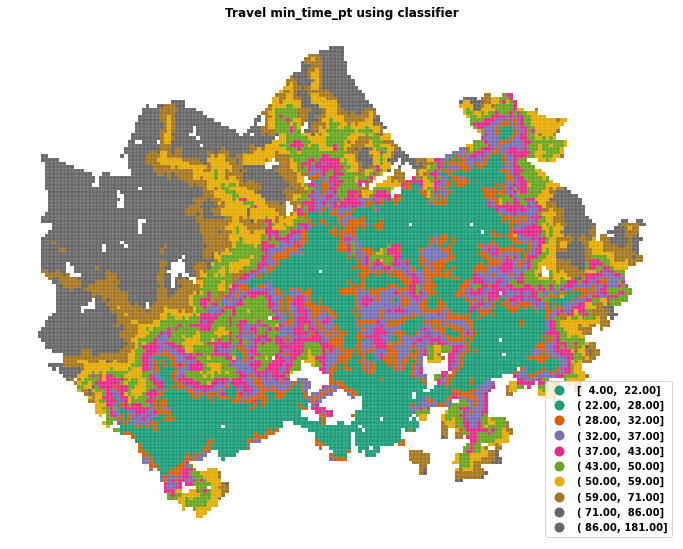

In [73]:
f, ax = plt.subplots(1, figsize=(12, 12))
df_gpd_MetropAccess_full.assign(cl_min_time_pt=q10.yb).plot(column='cl_min_time_pt', categorical=True, \
        k=10, cmap='Dark2', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True,
                          legend_kwds={'loc': 'lower right'})
ax.set_axis_off()
replace_legend_items(ax.get_legend(), mapping)
ax.set_title("Travel min_time_pt using classifier")
plt.show()

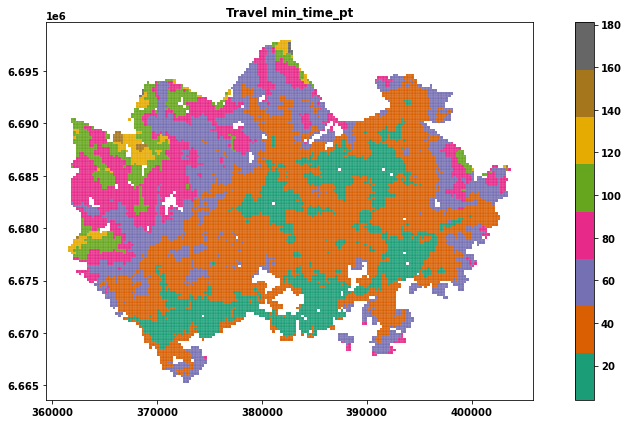

In [74]:
fig, ax = plt.subplots(figsize = (12, 6))
df_gpd_MetropAccess_full.reset_index().\
    plot(ax=ax, column='min_time_pt', legend = True, edgecolor='white', cmap ='Dark2', linewidth=0.1)
ax.set_title("Travel min_time_pt")
plt.tight_layout()    
plt.show() 

### 6.6. Visualize also the values in `dominant_service` column (no need to use any specific classifier). Notice that the value should be a number. If it is still as text, you need to convert it first.

In [75]:
df_gpd_MetropAccess_full.dominant_service.value_counts()

5902043    3817
5978593    3311
5878087    1927
5944003    1879
5975373     886
5878070     786
5980260     407
Name: dominant_service, dtype: int64

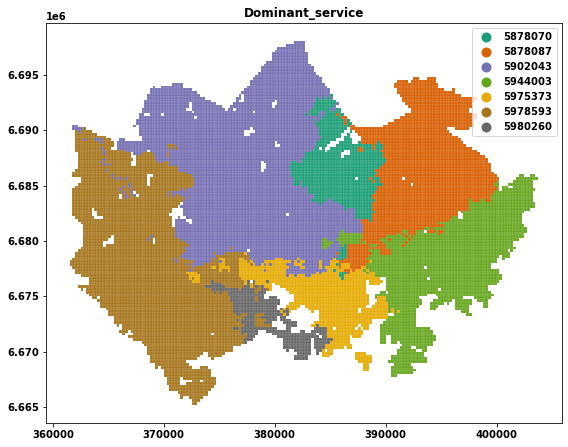

In [76]:
fig, ax = plt.subplots(figsize = (8, 8))
df_gpd_MetropAccess_full.reset_index().\
    plot(ax=ax, column='dominant_service', legend = True, edgecolor='white', cmap ='Dark2', linewidth=0.1)
ax.set_title("Dominant_service")
plt.tight_layout()    
plt.show() 